# **Graph Classification with 🤗 Transformers**

This notebook shows how to fine-tune the Graphormer model for Graph Classification on a dataset available on the hub. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/clefourrier/pcqm4mv2-graphormer-base checkpoint.

## Dependencies

Before we start, let's install the `datasets` and `transformers` libraries, as well as Cython, on which this model depends.

If you want to visualize your graphs, you also need to install `matplotlib` and `networkx`.

In [1]:
!pip install -q -U datasets transformers>=4.27.2 Cython
!pip install -q -U matplotlib networkx

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries. Transformers version must be > 4.27.2.

We check that Cython is correctly installed.

In [3]:
from transformers.utils import is_cython_available
print("Cython is installed:", is_cython_available())

Cython is installed: True


- To constrain the usage of the GPUs

In [5]:
import os as os
# To constrain the usage of GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = "2,1"

## For uploading the model and the result to the `Huggingface` community

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:
                                                                                 

In [6]:
from huggingface_hub import notebook_login

notebook_login()


Then you need to install Git-LFS to upload your model checkpoints:

In [7]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

## Fine-tuning Graphormer on an graph classification task

In this notebook, we will see how to fine-tune the Graphormer model on [🤗 Transformers](https://github.com/huggingface/transformers) on a Graph Classification dataset.

Given a graph, the goal is to predict its class.

### Loading the dataset

Loading a graph dataset from the Hub is very easy. Let's load the `ogbg-molhiv` dataset, stored in the `OGB` repository. 
*To find other graph datasets, look for the "Graph Machine Learning" tag on the hub:  [here](https://huggingface.co/datasets?task_categories=task_categories:graph-ml&sort=downloads). You'll find social graphs, molecular datasets, some artificial ones, etc!*

This dataset contains a collection of molecules (from MoleculeNet), and the goal is to predict if they to inhibit HIV or not. 


In [8]:
from datasets import load_dataset 

dataset = load_dataset("OGB/ogbg-molhiv")

Found cached dataset json (/workdir/home/euni/.cache/huggingface/datasets/OGB___json/OGB--ogbg-molhiv-84342e5c2b1dba71/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/3 [00:00<?, ?it/s]

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [9]:
from datasets import load_metric

metric = load_metric("accuracy")

/tmp/ipykernel_6454/1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, "train", "validation" and "test" splits).

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 32901
    })
    validation: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 4113
    })
    test: Dataset({
        features: ['edge_index', 'edge_attr', 'y', 'num_nodes', 'node_feat'],
        num_rows: 4113
    })
})

To access an actual element, you need to select a split first, then give an index:

In [11]:
print(dataset["train"][0])

Each example consists of an graph (made of its nodes, edges, and optional features) and a corresponding label. We can also verify this by checking the features of the dataset:

In [12]:
dataset["train"].features

{'edge_index': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'edge_attr': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'y': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'num_nodes': Value(dtype='int64', id=None),
 'node_feat': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None)}

We can inspect the graph using networkx and pyplot.

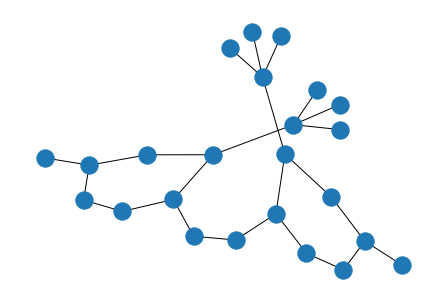

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
# We want to plot the first train graph
graph = dataset["train"][0]

edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

# Conversion to networkx format
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

# Plot
nx.draw(G)


In [15]:
# Let's print the corresponding label:
print("Label:", graph['y'])

### Preprocessing the data

Graph transformer frameworks usually apply specific preprocessing to their datasets to generate added features and properties which help the underlying learning task (classification in our case).

Here, we use Graphormer's default preprocessing, which generates in/out degree information, the shortest path between node matrices, and other properties of interest for the model. 

In [16]:
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

dataset_processed = dataset.map(preprocess_item, batched=False)

Map:   0%|          | 0/32901 [00:00<?, ? examples/s]

Map:   0%|          | 0/4113 [00:00<?, ? examples/s]

Map:   0%|          | 0/4113 [00:00<?, ? examples/s]

In [17]:
# split up training into training + validation
train_ds = dataset_processed['train']
val_ds = dataset_processed['validation']

Let's access an element to look at all the features we've added:

In [18]:
print(train_ds[0].keys())

### Training the model

Calling the `from_pretrained` method on our model downloads and caches the weights for us. As the number of classes (for prediction) is dataset dependent, we pass the new `num_classes` as well as `ignore_mismatched_sizes` alongside the `model_checkpoint`. This makes sure a custom classification head is created, specific to our task, hence likely different from the original decoder head. 

(When using a pretrained model, you must make sure the embeddings of your data have the same shape as the ones used to pretrain your model.)

In [19]:
from transformers import GraphormerForGraphClassification

model_checkpoint = "clefourrier/graphormer-base-pcqm4mv2" # pre-trained model from which to fine-tune

model = GraphormerForGraphClassification.from_pretrained(
    model_checkpoint, 
    num_classes=2,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of GraphormerForGraphClassification were not initialized from the model checkpoint at clefourrier/graphormer-base-pcqm4mv2 and are newly initialized because the shapes did not match:
- classifier.classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

For graph datasets, it is particularly important to play around with batch sizes and gradient accumulation steps to train on enough samples while avoiding out-of-memory errors. 

In [23]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    "graph-classification",
    logging_dir="graph-classification",
    
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,

    auto_find_batch_size=True, # batch size can be changed automatically to prevent OOMs
    gradient_accumulation_steps=10,
    dataloader_num_workers=4, 

    num_train_epochs=2,

    evaluation_strategy="epoch",
    logging_strategy="epoch",
    push_to_hub=False,
)

In the `Trainer` for graph classification, it is important to pass the specific data collator for the given graph dataset, which will convert individual graphs to batches for training. 

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=GraphormerDataCollator()
)

We can now train our model!

In [25]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/workdir/home/euni/anaconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

You can now upload the result of the training to the Hub with the following:

In [ ]:
trainer.push_to_hub()